In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [20]:
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
# !pip install -U --pre matplotlib  
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf') # 3.2+
mpl.rc('font', family='TH Sarabun New')

--2020-12-03 12:56:58--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2020-12-03 12:56:59--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98308 (96K) [application/octet-stream]
Saving to: ‘thsarabunnew-webfont.ttf.2’

thsarabunnew-webfon 100%[===================>]  96.00K  --.-KB/s    in 0.01s   

2020-12-03 12:56:59 (9.53 MB/s) - ‘

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
dataset_path = '/content/drive/MyDrive/resized_amulet.zip'
PATH = os.path.join(os.path.dirname(dataset_path), 'resized_amulet')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 16
IMG_SIZE = (224, 224)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/itcs476_pj2/train',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE
                                             )
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/itcs476_pj2/validation',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE
                                                  )

Found 257 files belonging to 10 classes.
Found 84 files belonging to 10 classes.


In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 3
Number of test batches: 3


In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [10]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [11]:
base_model.trainable = False

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [13]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dense(64, activation = "relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation = "relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation = "relu")(x)
outputs = tf.keras.layers.Dense(10)(x)
model = tf.keras.Model(inputs, outputs)

In [14]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 64)               

In [16]:
initial_epochs = 50
loss0, accuracy0 = model.evaluate(validation_dataset)

3/3 [==============================] - 0s 55ms/step - loss: 2.5546 - accuracy: 0.0833


In [17]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/50
17/17 [==============================] - 2s 98ms/step - loss: 2.4636 - accuracy: 0.0661 - val_loss: 2.3221 - val_accuracy: 0.0278
Epoch 2/50
17/17 [==============================] - 1s 85ms/step - loss: 2.2908 - accuracy: 0.1595 - val_loss: 2.2647 - val_accuracy: 0.0833
Epoch 3/50
17/17 [==============================] - 2s 89ms/step - loss: 2.1894 - accuracy: 0.1907 - val_loss: 2.2564 - val_accuracy: 0.0556
Epoch 4/50
17/17 [==============================] - 1s 86ms/step - loss: 2.1141 - accuracy: 0.2101 - val_loss: 2.2087 - val_accuracy: 0.1111
Epoch 5/50
17/17 [==============================] - 1s 86ms/step - loss: 2.0493 - accuracy: 0.2412 - val_loss: 2.1813 - val_accuracy: 0.1389
Epoch 6/50
17/17 [==============================] - 1s 88ms/step - loss: 1.9267 - accuracy: 0.3268 - val_loss: 2.1517 - val_accuracy: 0.2222
Epoch 7/50
17/17 [==============================] - 1s 87ms/step - loss: 1.8628 - accuracy: 0.3502 - val_loss: 2.1048 - val_accuracy: 0.2500
Epoch 8/50
17

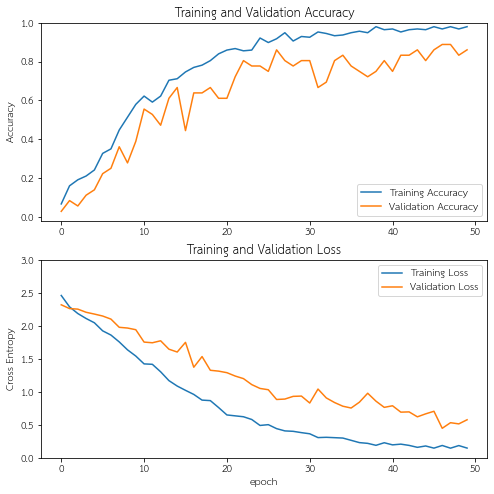

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [27]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

3/3 [==============================] - 0s 19ms/step - loss: 0.6481 - accuracy: 0.7708
Test accuracy : 0.7708333134651184


Predictions:
 [9 0 6 4 8 2 2 8 1 4 8 8 0 4 1 3]
Labels:
 [9 0 6 4 8 2 9 8 1 4 8 8 0 5 1 3]


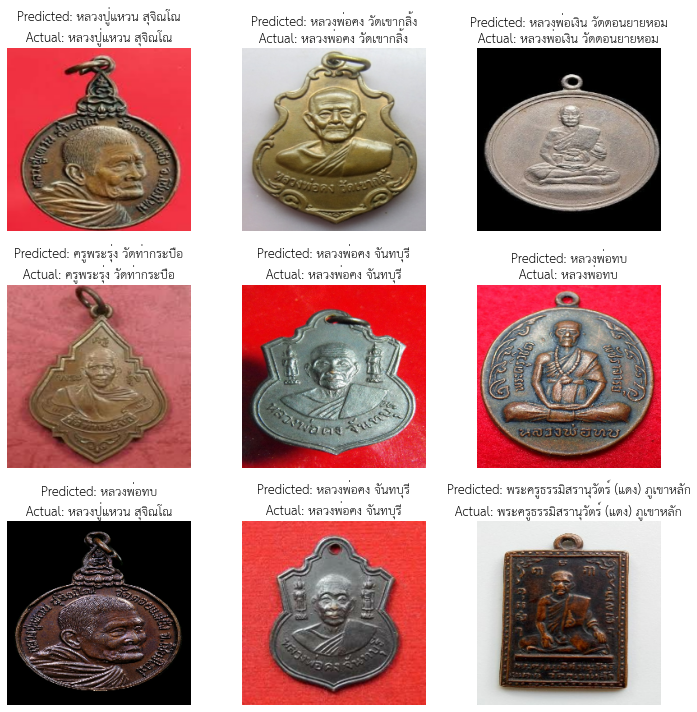

In [30]:
# -- coding: utf-8 --
class_names = ['หลวงพ่อคง วัดเขากลิ้ง',
               'พระครูธรรมิสรานุวัตร์ (แดง) ภูเขาหลัก',
               'หลวงพ่อทบ',
               'หลวงพ่อทวด วัดช้างไห้ รุ่นบุญรอด',
               'ครูพระรุ่ง วัดท่ากระบือ',
               'หลวงพ่อจง วัดหน้าต่างนอก',
               'หลวงพ่อเงิน วัดดอนยายหอม',
               'หลวงปู่ขาว อนาลโย',
               'หลวงพ่อคง จันทบุรี',
               'หลวงปู่แหวน สุจิณโณ']

#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).argmax(axis=-1)

# Apply a sigmoid since our model returns logits
# predictions = tf.nn.sigmoid(predictions)
# predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title("Predicted: " + class_names[predictions[i]] + '\nActual: ' + class_names[label_batch[i]])
  plt.axis("off")

plt.tight_layout()